In [32]:
# Standard library
import os
from argparse import ArgumentParser

# Third-party
import matplotlib
import matplotlib.pyplot as plt
import networkx
import numpy as np
import scipy.spatial
import skimage.draw
import torch
import torch_geometric as pyg
from torch_geometric.utils.convert import from_networkx

### Funciones suplementarias:

In [33]:
def plot_graph(graph, title=None, graph_type=None):
    fig, axis = plt.subplots(figsize=(12, 6), dpi=200)  # W,H
    edge_index = graph.edge_index
    pos = graph.pos

    # Fix for re-indexed edge indices only containing mesh nodes at
    # higher levels in hierarchy
    edge_index = edge_index - edge_index.min()

    if pyg.utils.is_undirected(edge_index):
        # Keep only 1 direction of edge_index
        edge_index = edge_index[:, edge_index[0] < edge_index[1]]  # (2, M/2)
    # TODO: indicate direction of directed edges

    # Move all to cpu and numpy, compute (in)-degrees
    degrees = (
        pyg.utils.degree(edge_index[1], num_nodes=pos.shape[0]).cpu().numpy()
    )
    edge_index = edge_index.cpu().numpy()
    pos = pos.cpu().numpy()

    # Plot edges
    from_pos = pos[edge_index[0]]  # (M/2, 2)
    to_pos = pos[edge_index[1]]  # (M/2, 2)
    edge_lines = np.stack((from_pos, to_pos), axis=1)
    axis.add_collection(
        matplotlib.collections.LineCollection(
            edge_lines, lw=0.4, colors="black", zorder=1
        )
    )

    # Plot nodes
    node_scatter = axis.scatter(
        pos[:, 0],
        pos[:, 1],
        c=degrees,
        s=3,
        marker="o",
        zorder=2,
        cmap="viridis",
        clim=None,
    )

    plt.colorbar(node_scatter, aspect=50)

    if title is not None:
        axis.set_title(title)
    #create directory if it does not exist
    if not os.path.exists(os.path.join("figures", graph_type)):
        os.makedirs(os.path.join("figures", graph_type))
    plt.savefig(os.path.join("figures", graph_type, f"{title}.png"))
    plt.close()


def sort_nodes_internally(nx_graph):
    # For some reason the networkx .nodes() return list can not be sorted,
    # but this is the ordering used by pyg when converting.
    # This function fixes this.
    H = networkx.DiGraph()
    H.add_nodes_from(sorted(nx_graph.nodes(data=True)))
    H.add_edges_from(nx_graph.edges(data=True))
    return H


def save_edges(graph, name, base_path):
    torch.save(
        graph.edge_index, os.path.join(base_path, f"{name}_edge_index.pt")
    )
    edge_features = torch.cat((graph.len.unsqueeze(1), graph.vdiff), dim=1).to(
        torch.float32
    )  # Save as float32
    torch.save(edge_features, os.path.join(base_path, f"{name}_features.pt"))


def save_edges_list(graphs, name, base_path):
    torch.save(
        [graph.edge_index for graph in graphs],
        os.path.join(base_path, f"{name}_edge_index.pt"),
    )
    edge_features = [
        torch.cat((graph.len.unsqueeze(1), graph.vdiff), dim=1).to(
            torch.float32
        )
        for graph in graphs
    ]  # Save as float32
    torch.save(edge_features, os.path.join(base_path, f"{name}_features.pt"))


def from_networkx_with_start_index(nx_graph, start_index):
    pyg_graph = from_networkx(nx_graph)
    pyg_graph.edge_index += start_index
    return pyg_graph


def crosses_land(node1, node2, land_mask, threshold=8):
    x1, y1 = node1
    x2, y2 = node2
    rr, cc = skimage.draw.line(round(y1), round(x1), round(y2), round(x2))
    return np.sum(land_mask[rr, cc]) >= threshold


def mk_2d_graph(xy, nx, ny, land_mask):
    xm, xM = np.amin(xy[0][0, :]), np.amax(xy[0][0, :])
    ym, yM = np.amin(xy[1][:, 0]), np.amax(xy[1][:, 0])

    # avoid nodes on border
    dx = (xM - xm) / nx
    dy = (yM - ym) / ny
    lx = np.linspace(xm + dx / 2, xM - dx / 2, nx, dtype=np.float32)
    ly = np.linspace(ym + dy / 2, yM - dy / 2, ny, dtype=np.float32)

    mg = np.meshgrid(lx, ly)
    g = networkx.grid_2d_graph(len(ly), len(lx))

    # kdtree for nearest neighbor search of land nodes
    land_points = np.argwhere(land_mask.T).astype(np.float32)
    land_kdtree = scipy.spatial.KDTree(land_points)

    # add nodes excluding land
    for node in list(g.nodes):
        node_pos = np.array([mg[0][node], mg[1][node]], dtype=np.float32)
        dist, _ = land_kdtree.query(node_pos, k=1)
        if dist < np.sqrt(0.5):
            g.remove_node(node)
        else:
            g.nodes[node]["pos"] = node_pos

    # add diagonal edges if both nodes exist
    for x in range(nx - 1):
        for y in range(ny - 1):
            if g.has_node((x, y)) and g.has_node((x + 1, y + 1)):
                g.add_edge((x, y), (x + 1, y + 1))
            if g.has_node((x + 1, y)) and g.has_node((x, y + 1)):
                g.add_edge((x + 1, y), (x, y + 1))

    # remove edges that goes across land
    for u, v in list(g.edges()):
        if crosses_land(g.nodes[u]["pos"], g.nodes[v]["pos"], land_mask):
            g.remove_edge(u, v)

    # turn into directed graph
    dg = networkx.DiGraph(g)

    # add node data
    for u, v in g.edges():
        d = np.sqrt(np.sum((g.nodes[u]["pos"] - g.nodes[v]["pos"]) ** 2))
        dg.edges[u, v]["len"] = d
        dg.edges[u, v]["vdiff"] = g.nodes[u]["pos"] - g.nodes[v]["pos"]
        dg.add_edge(v, u)
        dg.edges[v, u]["len"] = d
        dg.edges[v, u]["vdiff"] = g.nodes[v]["pos"] - g.nodes[u]["pos"]

    # add self edge if needed
    for v, degree in list(dg.degree()):
        if degree <= 1:
            dg.add_edge(v, v, len=0, vdiff=np.array([0, 0]))

    return dg


def prepend_node_index(graph, new_index):
    # Relabel node indices in graph, insert (graph_level, i, j)
    ijk = [tuple((new_index,) + x) for x in graph.nodes]
    to_mapping = dict(zip(graph.nodes, ijk))
    return networkx.relabel_nodes(graph, to_mapping, copy=True)

### Funciones Propias a Implementar

In [34]:
#print(lx + np.random.rand(len(lx)) * 0.1)
#print(np.random.rand(len(lx)) * 0.1)

def mk_2d_non_uniform_graph(xy, nx, ny, land_mask, lower_offset_bound=0, upper_offset_bound=0.4):
    """
    Create a 2D non-uniform graph using networkx where:
    - The function takes a mesh grid defined by the xy coordinates and the number of nodes in x and y direction.
    - The function generates positions for the nodes inside the mesh.
    - The function ensures that the positions of the nodes are not too close to each other by setting a minimum distance between them.
    - The function also ensures that the positions of the nodes are within the limits of the mesh.
    - The function ensures that the nodes are not placed on land by checking the land mask.
    - The function adds edges to the graph based on the Delaunay triangulation of the nodes.

    Params:
    xy: mesh grid coordinates
    nx, ny: number of nodes in x and y direction
    land_mask: mask of land nodes
    lower_offset_bound: lower bound for random offsets
    upper_offset_bound: upper bound for random offsets
    mode: mode of generation, either "random_offsets" or "random"

    returns:
    - dg: directed graph with nodes and edges
    """

    xm, xM = np.amin(xy[0][0, :]), np.amax(xy[0][0, :])
    ym, yM = np.amin(xy[1][:, 0]), np.amax(xy[1][:, 0])


    list_coords = generate_random_nodes_positions(nx, ny, xm, xM, ym, yM)

    g = networkx.Graph()
    for coord in list_coords:
        g.add_node(coord)

    # kdtree for nearest neighbor search of land nodes
    land_points = np.argwhere(land_mask.T).astype(np.float32)
    land_kdtree = scipy.spatial.KDTree(land_points)

    # add nodes excluding land
    for node in list(g.nodes):
        node_pos = np.array(node, dtype=np.float32)
        dist, _ = land_kdtree.query(node_pos, k=1)
        if dist < np.sqrt(0.5):
            g.remove_node(node)
        else:
            g.nodes[node]["pos"] = node_pos

    add_Delaunay_edges(g)

    # remove edges that goes across land
    for u, v in list(g.edges()):
        if crosses_land(g.nodes[u]["pos"], g.nodes[v]["pos"], land_mask):
            g.remove_edge(u, v)

    # turn into directed graph
    dg = networkx.DiGraph(g)

    # add node data
    for u, v in g.edges():
        d = np.sqrt(np.sum((g.nodes[u]["pos"] - g.nodes[v]["pos"]) ** 2))
        dg.edges[u, v]["len"] = d
        dg.edges[u, v]["vdiff"] = g.nodes[u]["pos"] - g.nodes[v]["pos"]
        dg.add_edge(v, u)
        dg.edges[v, u]["len"] = d
        dg.edges[v, u]["vdiff"] = g.nodes[v]["pos"] - g.nodes[u]["pos"]

    # add self edge if needed
    for v, degree in list(dg.degree()):
        if degree <= 1:
            dg.add_edge(v, v, len=0, vdiff=np.array([0, 0]))

    return dg

def add_diagonal_edges(nx, ny, g):
    """
    Add diagonal edges to a grid graph, where the graph neeeds to be a square uniform grid.
    The function iterates over the nodes in the grid and adds edges between diagonal nodes.

    Params:
    nx: number of nodes in x direction
    ny: number of nodes in y direction
    g: networkx graph object to which the diagonal edges will be added
    """
    for x in range(nx - 1):
        for y in range(ny - 1):
            if g.has_node((x, y)) and g.has_node((x + 1, y + 1)):
                g.add_edge((x, y), (x + 1, y + 1))
            if g.has_node((x + 1, y)) and g.has_node((x, y + 1)):
                g.add_edge((x + 1, y), (x, y + 1))

def add_Delaunay_edges(g):
    g.remove_edges_from(list(g.edges()))
    
    nodes_list = list(g.nodes())
    points = np.array([g.nodes[node]["pos"] for node in nodes_list])
    
    tri = scipy.spatial.Delaunay(points)
    
    for simplex in tri.simplices:
        for i in range(3):
            for j in range(i + 1, 3):
                node1 = nodes_list[simplex[i]]
                node2 = nodes_list[simplex[j]]
                if g.has_node(node1) and g.has_node(node2):
                    g.add_edge(node1, node2)


def generate_random_nodes_positions(nx, ny, xm, xM, ym, yM):
    """ 
    Generate random nodes positions inside the mesh

    returns = list of coordinates (x,y) of the nodes to create a Graph with networkx
    """
    N = nx * ny
    lx = np.random.uniform(xm, xM, N)
    ly = np.random.uniform(ym, yM, N)
    secure_positions_within_the_limit(xm, xM, ym, yM, (xM - xm) / nx, (yM - ym) / ny, lx, ly)
    list_coords = []
    for x, y in zip(lx, ly):
        coord = (x, y)
        list_coords.append(coord)
    return list_coords



def generate_mesh_positions_with_random_offsets(nx, ny, lower_offset_bound, upper_offset_bound, xm, xM, ym, yM):
    dx = (xM - xm) / nx
    dy = (yM - ym) / ny
    lx = np.linspace(xm + dx / 2, xM - dx / 2, nx, dtype=np.float32)
    ly = np.linspace(ym + dy / 2, yM - dy / 2, ny, dtype=np.float32)


    random_offset_x = np.random.uniform(lower_offset_bound, upper_offset_bound, len(lx))
    random_offset_y = np.random.uniform(lower_offset_bound, upper_offset_bound, len(ly))

    lx = lx + random_offset_x
    ly = ly + random_offset_y
    
    secure_positions_within_the_limit(xm, xM, ym, yM, dx, dy, lx, ly)
    return lx,ly

def secure_positions_within_the_limit(xm, xM, ym, yM, dx, dy, lx, ly):
    lx[0] = xm + dx / 2
    lx[-1] = xM - dx / 2

    for i in range(len(lx)):    
        if lx[i] < xm + dx / 2:
            lx[i] = xm + dx / 2
        if lx[i] > xM - dx / 2:
            lx[i] = xM - dx / 2
    
    ly[0] = ym + dy / 2
    ly[-1] = yM - dy / 2

    for i in range(len(ly)):
        if ly[i] < ym + dy / 2:
            ly[i] = ym + dy / 2
        if ly[i] > yM - dy / 2:
            ly[i] = yM - dy / 2

### Establecemos direcciones y valores simulando la entrada de datos de la terminal

In [35]:
plot = 1
dataset = "D:/ULPGC/4Curso/TFG/seacast_code/Proyecto_TFG/Seacast/data/atlantic"
graph_dir = "graphs"
graph = "hierarchical"
figures_dir = "figures"
levels_terminal = 3

### Carga de archivos necesarios

In [36]:
static_dir_path = os.path.join(dataset, "static")
graph_dir_path = os.path.join(graph_dir, graph)
os.makedirs(graph_dir_path, exist_ok=True)
if plot != 0:
    fig_dir_path = os.path.join(figures_dir, graph)
    os.makedirs(fig_dir_path, exist_ok=True)
xy = np.load(os.path.join(static_dir_path, "nwp_xy.npy"))
sea_mask = np.load(os.path.join(static_dir_path, "sea_mask.npy"))


In [37]:
land_mask = ~sea_mask[0]
grid_xy = torch.tensor(xy)
pos_max = torch.max(torch.abs(grid_xy))

In [38]:
n_x= 81
ny = 81
mx = 0
my = 0
Mx = 81
My = 81

list_coords = generate_random_nodes_positions(n_x, ny, mx, Mx, my, My)
g = networkx.Graph()
for coord in list_coords:
    g.add_node(coord)

land_points = np.argwhere(land_mask.T).astype(np.float32)
land_kdtree = scipy.spatial.KDTree(land_points)

for node in list(g.nodes):
    node_pos = np.array(node, dtype=np.float32)
    dist, _ = land_kdtree.query(node_pos, k=1)
    if dist < np.sqrt(0.5):
        g.remove_node(node)
    else:
        g.nodes[node]["pos"] = node_pos


add_Delaunay_edges(g)

In [39]:
pos = torch.tensor([[g.nodes[node]["pos"] for node in g.nodes]])

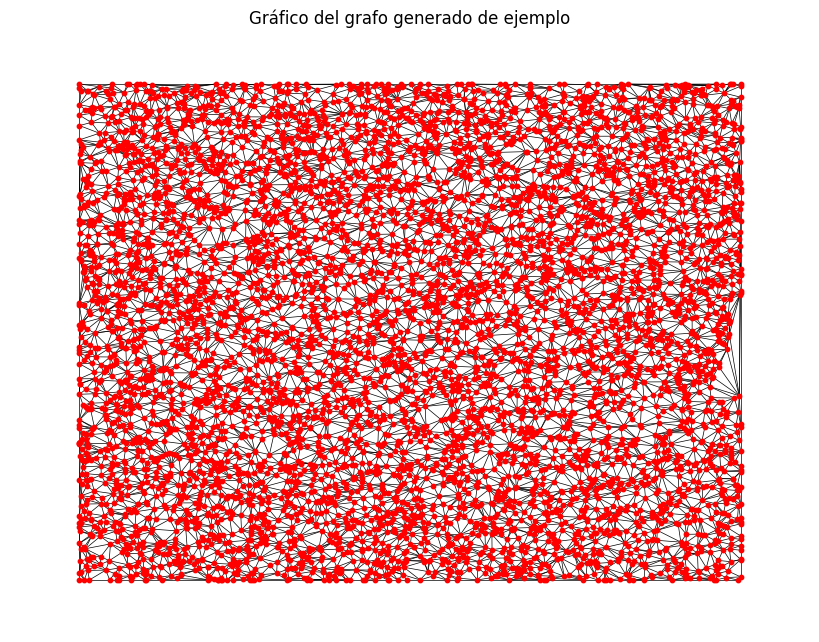

In [40]:
pos = networkx.get_node_attributes(g, "pos")

plt.figure(figsize=(8, 6))

networkx.draw(g, pos, node_size=10, width=0.5, edge_color='black', node_color='red', with_labels=False)

plt.title("Gráfico del grafo generado de ejemplo")
plt.show()

### Creación de las diferentes capas para la malla (Mesh):

In [41]:
nx = 3
lower_offset_bound = 0
upper_offset_bound = 4
nlev = int(np.log(max(xy.shape)) / np.log(nx))
nleaf = nx**nlev  # leaves at the bottom = nleaf**2
mesh_levels = nlev - 1
if levels_terminal is not None:
    mesh_levels = min(mesh_levels, levels_terminal)
    # Limit the levels in mesh graph
print(f"nlev: {nlev}, nleaf: {nleaf}, mesh_levels: {mesh_levels}")
# multi resolution tree levels
G = []
for lev in range(1, mesh_levels + 1):
    n = int(nleaf / (nx**lev))
    print(f"level {lev}, n: {n}")
    g = mk_2d_non_uniform_graph(xy, n, n, land_mask, lower_offset_bound, upper_offset_bound)
    if plot != 0:
        plot_graph(
            from_networkx(g),
            title=f"Mesh graph, level {lev}",
            graph_type=graph,
        )
    G.append(g)

nlev: 5, nleaf: 243, mesh_levels: 3
level 1, n: 81
level 2, n: 27
level 3, n: 9


## Parte del Hierarchical Mesh

En la primera parte se le añade una nueva dimensión a los nodos de los diferentes grafos del mesh de forma que se pueden identificar los nodos de los diferentes niveles.

In [42]:
# Relabel nodes of each level with level index first
G = [
    prepend_node_index(graph, level_i)
    for level_i, graph in enumerate(G)
]

num_nodes_level = np.array([len(g_level.nodes) for g_level in G])
# First node index in each level in the hierarchical graph
first_index_level = np.concatenate(
    (np.zeros(1, dtype=int), np.cumsum(num_nodes_level[:-1]))
)


In [43]:
# Create inter-level mesh edges
up_graphs = []
down_graphs = []
for from_level, to_level, G_from, G_to, start_index in zip(
    range(1, mesh_levels),
    range(0, mesh_levels - 1),
    G[1:],
    G[:-1],
    first_index_level[: mesh_levels - 1],
):
    # start out from graph at from level
    G_down = G_from.copy()
    G_down.clear_edges()
    G_down = networkx.DiGraph(G_down)
    # Add nodes of to level
    G_down.add_nodes_from(G_to.nodes(data=True))
    # build kd tree for mesh point pos
    # order in vm should be same as in vm_xy
    v_to_list = list(G_to.nodes)
    v_from_list = list(G_from.nodes)
    v_from_xy = np.array([xy for _, xy in G_from.nodes.data("pos")])
    kdt_m = scipy.spatial.KDTree(v_from_xy)
    # add edges from mesh to grid
    for v in v_to_list:
        # find k nearest neighbours (index to vm_xy)
        neigh_idx = kdt_m.query(G_down.nodes[v]["pos"], k=16)[1]
        for idx in neigh_idx:
            u = v_from_list[idx]
            # add edge from mesh to grid
            if not crosses_land(
                G_down.nodes[u]["pos"],
                G_down.nodes[v]["pos"],
                land_mask,
            ):
                G_down.add_edge(u, v)
                d = np.sqrt(
                    np.sum(
                        (
                            G_down.nodes[u]["pos"]
                            - G_down.nodes[v]["pos"]
                        )
                        ** 2
                    )
                )
                G_down.edges[u, v]["len"] = d
                G_down.edges[u, v]["vdiff"] = (
                    G_down.nodes[u]["pos"] - G_down.nodes[v]["pos"]
                )
                break
    # relabel nodes to integers (sorted)
    G_down_int = networkx.convert_node_labels_to_integers(
        G_down, first_label=start_index, ordering="sorted"
    )  # Issue with sorting here
    G_down_int = sort_nodes_internally(G_down_int)
    pyg_down = from_networkx_with_start_index(G_down_int, start_index)
        # Create up graph, invert downwards edges
    up_edges = torch.stack(
            (pyg_down.edge_index[1], pyg_down.edge_index[0]), dim=0
        )
    pyg_up = pyg_down.clone()
    pyg_up.edge_index = up_edges
    up_graphs.append(pyg_up)
    down_graphs.append(pyg_down)
    if plot != 0:
        plot_graph(
            pyg_down,
            title=f"Down graph, {from_level}_{to_level}",
            graph_type=graph,
        )
        plot_graph(
            pyg_down,
            title=f"Up graph, {to_level}_{from_level}",
            graph_type=graph,
        )

# Save up and down edges
save_edges_list(up_graphs, "mesh_up", graph_dir_path)
save_edges_list(down_graphs, "mesh_down", graph_dir_path)

### M2M

In [44]:
# Save m2m edges
        # Extract intra-level edges for m2m
m2m_graphs = [
    from_networkx_with_start_index(
        networkx.convert_node_labels_to_integers(
            level_graph, first_label=start_index, ordering="sorted"
        ),
        start_index,
    )
    for level_graph, start_index in zip(G, first_index_level)
]

mesh_pos = [graph.pos.to(torch.float32) for graph in m2m_graphs]
# For use in g2m and m2g
G_bottom_mesh = G[0]
joint_mesh_graph = networkx.union_all([graph for graph in G])
all_mesh_nodes = joint_mesh_graph.nodes(data=True)

save_edges_list(m2m_graphs, "m2m", graph_dir_path)

# Divide mesh node pos by max coordinate of grid cell
mesh_pos = [pos / pos_max for pos in mesh_pos]

# Save mesh positions
torch.save(
    mesh_pos, os.path.join(graph_dir_path, "mesh_features.pt")
)  # mesh pos, in float32

### Grid2Mesh

In [45]:
# radius within which grid nodes are associated with a mesh node
# (in terms of mesh distance)
DM_SCALE = 0.67

# mesh nodes on lowest level
vm = G_bottom_mesh.nodes
vm_xy = np.array([xy for _, xy in vm.data("pos")])

In [46]:
print(len(vm))
print(vm)
print(len(vm_xy))
print(vm_xy[1])

3616
[(0, np.float64(1.845679012345679), np.float64(1.845679012345679)), (0, np.float64(116.9596258543507), np.float64(107.09795083273562)), (0, np.float64(2.786301860746174), np.float64(47.411243333411974)), (0, np.float64(65.94033930592116), np.float64(25.161262074791388)), (0, np.float64(272.7187471415491), np.float64(284.47032359818996)), (0, np.float64(2.5457981791561326), np.float64(276.13481993327724)), (0, np.float64(3.9921118624829477), np.float64(177.9683410344364)), (0, np.float64(65.80358609070846), np.float64(145.30459218715254)), (0, np.float64(179.57620784832756), np.float64(195.23828798905103)), (0, np.float64(31.47495916828089), np.float64(87.78097266368553)), (0, np.float64(200.35599453312633), np.float64(261.3719446068486)), (0, np.float64(184.41424945868346), np.float64(222.67566139548754)), (0, np.float64(73.26972471618039), np.float64(67.55719236372316)), (0, np.float64(156.13064865984), np.float64(257.54444436717296)), (0, np.float64(170.94187803239345), np.float

# distance between mesh nodes
dm = np.sqrt(np.sum((vm.data("pos")[key1] - vm.data("pos")[key2]) ** 2))


In [47]:
def calculate_IQR_distances_between_nodes(vm_xy, iqr_thresholds=[25, 50, 75]):
    """
    Calculate the given percentiles of the distances between the nodes of the mesh and the min and max values
    in order to assign a threshold to the distances and maintain a good connectivity of the mesh.

    Parameters

    vm_xy: numpy array
        Array with the positions of the nodes of the mesh

    Returns

    iqr_distances: list
        List with the min value, the percentiles and the max value
        of the distances between the nodes of the mesh
    """
    distances = []
    for i in range(len(vm_xy)):
        for j in range(i+1, len(vm_xy)):
            distances.append(np.sqrt(np.sum((vm_xy[i] - vm_xy[j]) ** 2)))
    iqr_distances = []
    for threshold in iqr_thresholds:
        iqr = np.percentile(distances, threshold)
        iqr_distances.append(iqr)
    iqr_distances.sort()
    #sort distances in ascending order
    distances.sort()
    #plot distances
    plt.plot(distances)
    plt.xlabel("Distances")
    plt.ylabel("Value")
    plt.title("Distances between nodes of the mesh")
    plt.show()
    return iqr_distances

In [48]:
#all_distances = calculate_distances_between_nodes(vm_xy)
#print("Distancias entre los nodos de la malla: ", all_distances)


In [49]:
#all_distances = sorted(all_distances)
##plot 
#plt.figure(figsize=(8, 6))
#plt.plot(all_distances)
#plt.title("DistanciaAs entre los nodos de la malla")
#plt.show()

In [50]:
iqr_thresholds = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
#dm = calculate_IQR_distances_between_nodes(vm_xy, iqr_thresholds)
#dm = calculate_mean_distances_between_nodes(vm_xy)
#print("Distancia entre nodos de la malla: ", dm)

In [51]:
# grid nodes
Ny, Nx = xy.shape[1:]
print(Ny, Nx)

300 300


In [52]:
G_grid = networkx.grid_2d_graph(Ny, Nx)
G_grid.clear_edges()

# vg features (only pos introduced here)
nodes_to_remove = []
for node in G_grid.nodes:
    # Remove the node from the graph if it is a land node
    if land_mask[node[0], node[1]]:
        nodes_to_remove.append(node)
    else:
        # pos is in feature but here explicit for convenience
        G_grid.nodes[node]["pos"] = np.array([xy[0][node], xy[1][node]])

for node in nodes_to_remove:
    G_grid.remove_node(node)


In [53]:
print(G_grid.nodes)
#ver el pos de los nodos
#for node in G_grid.nodes:
#    print(G_grid.nodes[node]["pos"])

[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (0, 16), (0, 17), (0, 18), (0, 19), (0, 20), (0, 21), (0, 22), (0, 23), (0, 24), (0, 25), (0, 26), (0, 27), (0, 28), (0, 29), (0, 30), (0, 31), (0, 32), (0, 33), (0, 34), (0, 35), (0, 36), (0, 37), (0, 38), (0, 39), (0, 40), (0, 41), (0, 42), (0, 43), (0, 44), (0, 45), (0, 46), (0, 47), (0, 48), (0, 49), (0, 50), (0, 51), (0, 52), (0, 53), (0, 54), (0, 55), (0, 56), (0, 57), (0, 58), (0, 59), (0, 60), (0, 61), (0, 62), (0, 63), (0, 64), (0, 65), (0, 66), (0, 67), (0, 68), (0, 69), (0, 70), (0, 71), (0, 72), (0, 73), (0, 74), (0, 75), (0, 76), (0, 77), (0, 78), (0, 79), (0, 80), (0, 81), (0, 82), (0, 83), (0, 84), (0, 85), (0, 86), (0, 87), (0, 88), (0, 89), (0, 90), (0, 91), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1

In [54]:
# add 1000 to node key to separate grid nodes (1000,i,j) from mesh nodes
# (i,j) and impose sorting order such that vm are the first nodes
G_grid = prepend_node_index(G_grid, 1000)


In [55]:
print(G_grid)

Graph with 49061 nodes and 0 edges


In [56]:
# build kd tree for grid point pos
# order in vg_list should be same as in vg_xy
vg_list = list(G_grid.nodes)
vg_xy = np.array([[xy[0][node[1:]], xy[1][node[1:]]] for node in vg_list])
kdt_g = scipy.spatial.KDTree(vg_xy)

In [57]:
print(vg_list)
print(vg_xy)

[(1000, 0, 0), (1000, 0, 1), (1000, 0, 2), (1000, 0, 3), (1000, 0, 4), (1000, 0, 5), (1000, 0, 6), (1000, 0, 7), (1000, 0, 8), (1000, 0, 9), (1000, 0, 10), (1000, 0, 11), (1000, 0, 12), (1000, 0, 13), (1000, 0, 14), (1000, 0, 15), (1000, 0, 16), (1000, 0, 17), (1000, 0, 18), (1000, 0, 19), (1000, 0, 20), (1000, 0, 21), (1000, 0, 22), (1000, 0, 23), (1000, 0, 24), (1000, 0, 25), (1000, 0, 26), (1000, 0, 27), (1000, 0, 28), (1000, 0, 29), (1000, 0, 30), (1000, 0, 31), (1000, 0, 32), (1000, 0, 33), (1000, 0, 34), (1000, 0, 35), (1000, 0, 36), (1000, 0, 37), (1000, 0, 38), (1000, 0, 39), (1000, 0, 40), (1000, 0, 41), (1000, 0, 42), (1000, 0, 43), (1000, 0, 44), (1000, 0, 45), (1000, 0, 46), (1000, 0, 47), (1000, 0, 48), (1000, 0, 49), (1000, 0, 50), (1000, 0, 51), (1000, 0, 52), (1000, 0, 53), (1000, 0, 54), (1000, 0, 55), (1000, 0, 56), (1000, 0, 57), (1000, 0, 58), (1000, 0, 59), (1000, 0, 60), (1000, 0, 61), (1000, 0, 62), (1000, 0, 63), (1000, 0, 64), (1000, 0, 65), (1000, 0, 66), (100

In [58]:
# now add (all) mesh nodes, include features (pos)
G_grid.add_nodes_from(all_mesh_nodes)


In [59]:
print(G_grid)
print(G_grid.nodes)

Graph with 53121 nodes and 0 edges
[(1000, 0, 0), (1000, 0, 1), (1000, 0, 2), (1000, 0, 3), (1000, 0, 4), (1000, 0, 5), (1000, 0, 6), (1000, 0, 7), (1000, 0, 8), (1000, 0, 9), (1000, 0, 10), (1000, 0, 11), (1000, 0, 12), (1000, 0, 13), (1000, 0, 14), (1000, 0, 15), (1000, 0, 16), (1000, 0, 17), (1000, 0, 18), (1000, 0, 19), (1000, 0, 20), (1000, 0, 21), (1000, 0, 22), (1000, 0, 23), (1000, 0, 24), (1000, 0, 25), (1000, 0, 26), (1000, 0, 27), (1000, 0, 28), (1000, 0, 29), (1000, 0, 30), (1000, 0, 31), (1000, 0, 32), (1000, 0, 33), (1000, 0, 34), (1000, 0, 35), (1000, 0, 36), (1000, 0, 37), (1000, 0, 38), (1000, 0, 39), (1000, 0, 40), (1000, 0, 41), (1000, 0, 42), (1000, 0, 43), (1000, 0, 44), (1000, 0, 45), (1000, 0, 46), (1000, 0, 47), (1000, 0, 48), (1000, 0, 49), (1000, 0, 50), (1000, 0, 51), (1000, 0, 52), (1000, 0, 53), (1000, 0, 54), (1000, 0, 55), (1000, 0, 56), (1000, 0, 57), (1000, 0, 58), (1000, 0, 59), (1000, 0, 60), (1000, 0, 61), (1000, 0, 62), (1000, 0, 63), (1000, 0, 64),

In [60]:
# Re-create graph with sorted node indices
# Need to do sorting of nodes this way for indices to map correctly to pyg
G_g2m = networkx.Graph()
G_g2m.add_nodes_from(sorted(G_grid.nodes(data=True)))

# turn into directed graph
G_g2m = networkx.DiGraph(G_g2m)

In [61]:
print(G_g2m)

DiGraph with 53121 nodes and 0 edges


In [ ]:
def establish_edge_with_distances_range(graph, distances, lowest_level_mesh, vg_list,xy, min_neighboors=3, max_neighboors=16):
    """
    Establish the edges between the nodes of the mesh and the nodes of the grid
    according to the distances between the nodes of the mesh and the nodes of the grid.

    Parameters

    graph: networkx graph
        Graph where the edges will be established (Usually G2M Graph)
    
    distances: list
        List with the min value, the percentiles and the max value
        of the distances between the nodes of the mesh
    
    lowest_level_mesh: networkx graph
        Graph with the nodes of the lowest level of the mesh (with highest resolition)
    
    DM_SCALE: float
        Scale factor to establish the distance range between the nodes of the mesh and the nodes of the grid

    vg_list: list
        List with the nodes of the grid
    
    """
    # dictionary with node as key and number of connections as value
    grid_nodes_connected = {}
    vg_xy = np.array([[xy[0][node[1:]], xy[1][node[1:]]] for node in vg_list])
    kdt_g = scipy.spatial.KDTree(vg_xy)

    while len(grid_nodes_connected) < len(vg_list):
        for mesh_node in lowest_level_mesh:
            n_connections = 0
            for distance in distances:
                # find k nearest neighbours (index to vg_xy)
                neigh_idx = kdt_g.query_ball_point(lowest_level_mesh[mesh_node]["pos"], distance * DM_SCALE)
                for idx in neigh_idx:
                    grid_node = vg_list[idx]
                    #if n_connections == max_neighboors: #and distance != distances[0]s
                    #    break
                    graph.add_edge(grid_node, mesh_node)
                    add_features(graph, mesh_node, grid_node)
                    n_connections += 1
                    #grid_nodes_connected[grid_node]+=1
                    if n_connections >= max_neighboors:
                        break
                #add node to the dictionary
                    grid_nodes_connected[grid_node] = n_connections
                if n_connections >= min_neighboors:
                    break

        if n_connections < min_neighboors:
            # find min_neighbors nearest neighbours
            neigh_idx = kdt_g.query(lowest_level_mesh[mesh_node]["pos"], min_neighboors)[1]
            for idx in neigh_idx:
                grid_node = vg_list[idx]
                graph.add_edge(grid_node, mesh_node)
                add_features(graph, mesh_node, grid_node)

                    #delete same edges
    #delete_same_edges(graph)

        

def add_features(graph, mesh_node, grid_node):
    d = np.sqrt(np.sum((graph.nodes[grid_node]["pos"] - graph.nodes[mesh_node]["pos"]) ** 2))
    graph.edges[grid_node, mesh_node]["len"] = d
    graph.edges[grid_node, mesh_node]["vdiff"] = (
                        graph.nodes[grid_node]["pos"] - graph.nodes[mesh_node]["pos"]
                        )

In [ ]:
def establish_edge_with_distances_range(graph, distances, lowest_level_mesh, DM_SCALE, vg_list,xy, min_neighboors=3, max_neighboors=16):
    """
    Sets the edges between mesh nodes and grid nodes using distance thresholds scaled by DM_SCALE.

        Parameters:
        -----------
        graph : networkx.Graph
        Graph where the edges will be set.
        distances : list
        List of distance thresholds (minimum, percentiles, maximum).
        lowest_level_mesh : networkx.Graph
        Graph with the highest resolution mesh nodes.
        DM_SCALE : float
        Scale factor for the distance thresholds.
        vg_list : list
        List of grid node IDs.
        min_neighboors : int, optional
        Minimum number of connections per mesh node (default=3).
        max_neighboors : int, optional
        Maximum number of connections per mesh node (default=16).
    """
    grid_nodes_connected = {node: 0 for node in vg_list}

    vg_xy = np.array([[xy[0][node[1:]], xy[1][node[1:]]] for node in vg_list])
    kdt_g = scipy.spatial.KDTree(vg_xy)

    for mesh_node in lowest_level_mesh:
        n_connections = 0
        mesh_pos = lowest_level_mesh[mesh_node]["pos"]
        for dist_threshold in distances:
            threshold = dist_threshold * DM_SCALE
            neigh_indices = kdt_g.query_ball_point(mesh_pos, threshold)
            for idx in neigh_indices:
                if n_connections >= max_neighboors:
                    break
                grid_node = vg_list[idx]
                if not graph.has_edge(grid_node, mesh_node):
                    graph.add_edge(grid_node, mesh_node)
                    add_features(graph, mesh_node, grid_node)
                    n_connections += 1
                    grid_nodes_connected[grid_node] += 1
            if n_connections >= min_neighboors:
                break

        if n_connections < min_neighboors:
            _, neigh_indices = kdt_g.query(mesh_pos, k=min_neighboors)
            if np.isscalar(neigh_indices):
                neigh_indices = [neigh_indices]
            for idx in neigh_indices:
                grid_node = vg_list[idx]
                if not graph.has_edge(grid_node, mesh_node):
                    graph.add_edge(grid_node, mesh_node)
                    add_features(graph, mesh_node, grid_node)
                    grid_nodes_connected[grid_node] += 1

    for grid_node, count in grid_nodes_connected.items():
        if count == 0:
            best_mesh, best_distance = None, float('inf')
            grid_pos = graph.nodes[grid_node]["pos"]
            for mesh_node in lowest_level_mesh:
                mesh_pos = lowest_level_mesh[mesh_node]["pos"]
                d = np.linalg.norm(np.array(grid_pos) - np.array(mesh_pos))
                if d < best_distance:
                    best_distance = d
                    best_mesh = mesh_node
            if best_mesh is not None and not graph.has_edge(grid_node, best_mesh):
                graph.add_edge(grid_node, best_mesh)
                add_features(graph, best_mesh, grid_node)
                grid_nodes_connected[grid_node] += 1


def add_features(graph, mesh_node, grid_node):
    d = np.sqrt(np.sum((graph.nodes[grid_node]["pos"] - graph.nodes[mesh_node]["pos"]) ** 2))
    graph.edges[grid_node, mesh_node]["len"] = d
    graph.edges[grid_node, mesh_node]["vdiff"] = (
                        graph.nodes[grid_node]["pos"] - graph.nodes[mesh_node]["pos"]
                        )
    



In [64]:
import numpy as np
import scipy.spatial

def establish_n_edges_g2m(graph, vm, vg_list, xy, required_connections, coef=np.inf, max_connections=16):
    """
    Establishes connections between grid nodes and mesh nodes in the graph.

    Parameters:
        graph : networkx.Graph
            Graph in which the edges will be added.
        vm : list
            List of nodes, where mesh nodes are considered to be those whose first element
            in the tuple is 0.
        vg_list : list
            List of grid nodes (expected to be in the form (1000, x, y)).
        xy : any
            Unused variable in this version (could be removed or used for further optimizations).
        required_connections : int
            Number of connections to establish for each node (both grid and mesh).
        coef : float, optional
            Coefficient used to determine whether the distance between nodes is large enough 
            to avoid creating a connection. If this feature is not needed, set coef=inf.

    Function Behavior:
        1. For each grid node, finds its `required_connections` closest mesh nodes and creates the connections.
        2. Ensures that each mesh node has at least `required_connections` connections by adding the missing 
        ones to the closest grid nodes that are not yet connected.

    Returns:
        None
            The function modifies the graph in place by adding edges between nodes.
    """
    grid_nodes_connected = {node: 0 for node in vg_list}
    mesh_nodes = [node for node in vm if node[0] == 0]
    mesh_node_connected = {node: 0 for node in mesh_nodes}

    mesh_positions = np.array([np.array(graph.nodes[node]["pos"]) for node in mesh_nodes])
    
    # Connect each grid node to its "required_connections" closest mesh nodes
    for grid_node in vg_list:
        grid_pos = np.array(graph.nodes[grid_node]["pos"])
        # calculate the distances from the grid node to all mesh nodes 
        dists = np.linalg.norm(mesh_positions - grid_pos, axis=1)
        sorted_indices = np.argsort(dists)
        for idx in sorted_indices[:required_connections]:
            mesh_node = mesh_nodes[idx]
            if not graph.has_edge(grid_node, mesh_node):
                graph.add_edge(grid_node, mesh_node)
                add_features(graph, mesh_node, grid_node)
                grid_nodes_connected[grid_node] += 1
                mesh_node_connected[mesh_node] += 1

    # Ensure taht each mesh node has at least "required_connections" connections
    grid_positions = np.array([np.array(graph.nodes[node]["pos"]) for node in vg_list])
    grid_tree = scipy.spatial.KDTree(grid_positions)

    for mesh_node in mesh_nodes:
        while mesh_node_connected[mesh_node] < required_connections:
            mesh_pos = np.array(graph.nodes[mesh_node]["pos"])
            dists, indices = grid_tree.query(mesh_pos, k=len(vg_list))
            found = False
            for idx in indices:
                candidate = vg_list[idx]
                if not graph.has_edge(candidate, mesh_node):
                    graph.add_edge(candidate, mesh_node)
                    add_features(graph, mesh_node, candidate)
                    grid_nodes_connected[candidate] += 1
                    mesh_node_connected[mesh_node] += 1
                    found = True
                    break
            if not found:
                break

In [65]:
def establish_edges_based_in_proportion(graph, vm, vg_list, proportion, min_connections):
    """
    Establish edges between mesh nodes and grid nodes based on a given proportion where:
    - The proportion is used to determine the radius of connection between mesh nodes and grid nodes.
    - The function connects the mesh nodes to the grid nodes within the radius determined by the proportion.
    - If the grid nodes are not connected to any mesh node, it connects them to the nearest mesh node.

    Params:
    graph: networkx.Graph
        Graph in which the edges will be added.
    vm: list
        List of nodes, where the mesh nodes are those whose first element of the tuple is 0.
    vg_list: list
        List of grid nodes (expected to have the form (1000, x, y)).
    proportion: float
        Proportion used to determine the radius of connection between mesh nodes and grid nodes.
        The radius is calculated as the square root of the proportion divided by 2.

    returns:
    - None: The function modifies the graph in place by adding edges between the nodes.
    """

    grid_nodes_connected = {node: 0 for node in vg_list}
    mesh_nodes = [node for node in vm if node[0] == 0]
    mesh_node_connected = {node: 0 for node in mesh_nodes}
    
    radio = int(np.ceil(np.sqrt(proportion) / 2))
    
    grid_positions = np.array([np.array(graph.nodes[node]["pos"]) for node in vg_list])
    grid_tree = scipy.spatial.KDTree(grid_positions)
    
    for mesh_node in mesh_nodes:
        mesh_pos = np.array(graph.nodes[mesh_node]["pos"])
        indices = grid_tree.query_ball_point(mesh_pos, r= radio)
        for idx in indices:
            if idx == len(vg_list):
                continue
            grid_node = vg_list[idx]
            if not graph.has_edge(grid_node, mesh_node):
                graph.add_edge(grid_node, mesh_node)
                add_features(graph, mesh_node, grid_node)
                grid_nodes_connected[grid_node] += 1
                mesh_node_connected[mesh_node] += 1

    mesh_positions = np.array([np.array(graph.nodes[node]["pos"]) for node in mesh_nodes])
    mesh_tree = scipy.spatial.KDTree(mesh_positions)
    
    for grid_node, count in grid_nodes_connected.items():
        if count < min_connections:
            grid_pos = np.array(graph.nodes[grid_node]["pos"])
            _, indices = mesh_tree.query(grid_pos, k=len(mesh_nodes))
            for idx in indices:
                if grid_nodes_connected[grid_node] >= min_connections:
                    break
                mesh_node = mesh_nodes[idx]
                if not graph.has_edge(grid_node, mesh_node):
                    graph.add_edge(grid_node, mesh_node)
                    add_features(graph, mesh_node, grid_node)
                    grid_nodes_connected[grid_node] += 1
                    mesh_node_connected[mesh_node] += 1
    return graph


In [66]:
number_of_grid_nodes = len([node for node in G_g2m.nodes if node[0] == 1000])
number_of_mesh_nodes = len([node for node in G_g2m.nodes if node[0] == 0])


offset_percentage = 0.75

#max_connections = int(proportion + proportion * offset_percentage)
#print("Número máximo de conexiones: ", max_connections)

In [67]:
#coef = 1+DM_SCALE
#coef = 1.6
min_connections = 3
#max_connections = int(max_connections * np.sqrt(min_connections))
#print("Número máximo de conexiones: ", max_connections)
#proportion rounded up
proportion = int(np.ceil(number_of_grid_nodes / number_of_mesh_nodes)) * min_connections
print(proportion)
print("Proporción entre nodos de la malla y nodos de la grilla: ", proportion)

establish_n_edges_g2m(G_g2m, vm, vg_list, xy, min_connections)

#establish_edges_based_in_proportion(G_g2m, vm, vg_list, proportion, min_connections=min_connections)


42
Proporción entre nodos de la malla y nodos de la grilla:  42


In [68]:
#min_neighboors = 3
#max_neighboors = 30
#distance_increment = 50
#establish_edge_with_distances_range(G_g2m, dm, vm, DM_SCALE, vg_list, xy,
#                                     min_neighboors, max_neighboors
#                                     #distance_increment=distance_increment
#                                     )

In [69]:
print(G_g2m)
# print node with maximun and minimun degree  and the number of connections
max_degree = 0
min_degree = 100000
max_node = None
min_node = None
for node in G_g2m.nodes:
    degree = G_g2m.degree(node)
    if degree > max_degree:
        max_degree = degree
        max_node = node
    if degree < min_degree:
        min_degree = degree
        min_node = node
print("Nodo con mayor grado: ", max_node, " con grado: ", max_degree)
print("Nodo con menor grado: ", min_node, " con grado: ", min_degree)
#print number of connections of every node and save to a file
with open("connections.txt", "w") as file:
    for node in G_g2m.nodes:
        degree = G_g2m.degree(node)
        file.write(f"Nodo {node} con grado {degree}\n")


DiGraph with 53121 nodes and 147183 edges
Nodo con mayor grado:  (0, np.float64(218.5725187466815), np.float64(244.50924210658152))  con grado:  95
Nodo con menor grado:  (1, np.float64(5.537037037037037), np.float64(5.537037037037037))  con grado:  0


In [84]:
import numpy as np 
from collections import Counter

def compute_metrics(degree_counter):
    if not degree_counter:
        return {
            "total_nodes": 0,
            "min_degree": None,
            "max_degree": None,
            "average_degree": None,
            "median_degree": None,
            "percentile_25_degree": None,
            "percentile_75_degree": None,
            "IQR_degree": None,
            "count_degrees": {}
        }
    grados = list(degree_counter.elements())
    return {
        "total_nodes": len(grados),
        "min_degree": min(grados),
        "max_degree": max(grados),
        "average_degree": sum(grados) / len(grados),
        "median_degree": np.median(grados),
        "percentile_25_degree": np.percentile(grados, 25),
        "percentile_75_degree": np.percentile(grados, 75),
        "IQR_degree": np.percentile(grados, 75) - np.percentile(grados, 25),
        "count_degrees": dict(degree_counter)
    }

def metrics_from_networkx_graph(graph, level_to_consider=None):
    """
    Extracts connection metrics from a NetworkX graph.

    If 'level_to_consider' is specified, nodes whose first element of 
    the identifier is equal to that level are filtered out.
    Otherwise, metrics are calculated for all nodes.
    """
    if level_to_consider is not None:
        filtered_nodes = [node for node in graph.nodes if node[0] == level_to_consider]
        degree_mapping = dict(graph.degree(filtered_nodes))
        degree_counter = Counter(degree_mapping.values())
    else:
        degree_mapping = dict(graph.degree())
        degree_counter = Counter(degree_mapping.values())

    metrics = compute_metrics(degree_counter)
    return metrics


In [85]:
grid_metrics = metrics_from_networkx_graph(G_g2m, 1000)
mesh_metrics = metrics_from_networkx_graph(G_g2m, 0)
print("Métricas de conexión para nodos de grilla:")
for key, value in grid_metrics.items():
    if key != "count_degrees":
        print(f"{key}: {value}")
if "count_degrees" in grid_metrics:
    print("Distribución de grados:")
    for degree, count in sorted(grid_metrics["count_degrees"].items()):
        print(f"Grado {degree}: {count} nodos")
        
print("-----------------------")
print("Métricas de conexión para nodos de malla:")
for key, value in mesh_metrics.items():
    if key != "count_degrees":
        print(f"{key}: {value}")
if "count_degrees" in mesh_metrics:
    print("Distribución de grados:")
    for degree, count in sorted(mesh_metrics["count_degrees"].items()):
        print(f"Grado {degree}: {count} nodos")



Métricas de conexión para nodos de grilla:
total_nodes: 49061
min_degree: 3
max_degree: 3
average_degree: 3.0
median_degree: 3.0
percentile_25_degree: 3.0
percentile_75_degree: 3.0
IQR_degree: 0.0
Distribución de grados:
Grado 3: 49061 nodos
-----------------------
Métricas de conexión para nodos de malla:
total_nodes: 3616
min_degree: 10
max_degree: 95
average_degree: 40.70326327433628
median_degree: 40.0
percentile_25_degree: 32.0
percentile_75_degree: 48.0
IQR_degree: 16.0
Distribución de grados:
Grado 10: 1 nodos
Grado 11: 2 nodos
Grado 12: 2 nodos
Grado 13: 2 nodos
Grado 14: 6 nodos
Grado 15: 6 nodos
Grado 16: 12 nodos
Grado 17: 9 nodos
Grado 18: 18 nodos
Grado 19: 20 nodos
Grado 20: 23 nodos
Grado 21: 42 nodos
Grado 22: 62 nodos
Grado 23: 41 nodos
Grado 24: 68 nodos
Grado 25: 64 nodos
Grado 26: 60 nodos
Grado 27: 87 nodos
Grado 28: 96 nodos
Grado 29: 73 nodos
Grado 30: 91 nodos
Grado 31: 93 nodos
Grado 32: 100 nodos
Grado 33: 105 nodos
Grado 34: 126 nodos
Grado 35: 110 nodos
Grad

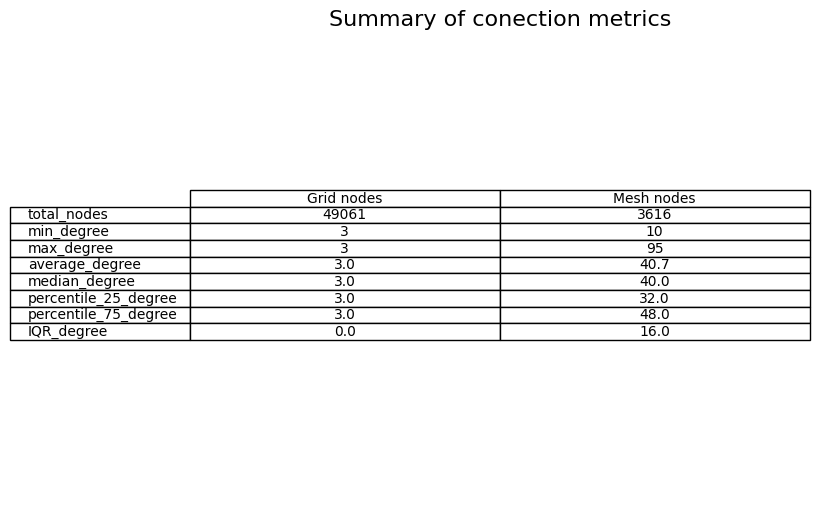

In [86]:
def create_metrics_table(grid_metrics, mesh_metrics, columns_names, metrics_to_avoid, title, graph_type,save_dir="figures"):
    """
    Create a table with the metrics of the sender and reciver graphs.
    Parameters:
    grid_metrics: dict
        Dictionary with the metrics of the sender graph.
    mesh_metrics: dict
        Dictionary with the metrics of the reciver graph.
    columns_names: list
        List with the names of the columns.
    metrics_to_avoid: list
        List with the names of the metrics to avoid.
    title: str
        Title of the table.
    graph_type: str
        Type of graph.
    save_dir: str
        Directory where to save the table.
    """
    metric_labels = [key for key in grid_metrics.keys() if key not in metrics_to_avoid]

    rows = metric_labels
    if mesh_metrics is None:
        #create a single column table with the grid metrics
        data = [[grid_metrics[label]] for label in metric_labels]
        data = [[round(value, 2) for value in row] for row in data]
    else:
        data = [[grid_metrics[label], mesh_metrics[label]] for label in metric_labels]
        data = [[round(value, 2) for value in row] for row in data]
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.axis('tight')
    ax.axis('off')
    table = ax.table(cellText=data, 
                 rowLabels=rows, 
                 colLabels=columns_names, 
                 loc='center',
                 cellLoc='center')
    
    ax.set_title(title, fontsize=16)
    directory = os.path.join(save_dir, graph_type) if graph_type is not None else save_dir
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    filepath = os.path.join(directory, f"{title}.svg")
    plt.savefig(filepath, format="svg")
    plt.show()

create_metrics_table(grid_metrics, mesh_metrics, 
                     columns_names=["Grid nodes", "Mesh nodes"],
                       metrics_to_avoid=["count_degrees"], 
                       title="Summary of conection metrics", 
                       graph_type="3conexiones_grid")



In [ ]:
def plot_degree_distribution(degree_counter, title, graph_type=None):
    """
    Graphs the degree distribution using a degree counter.

    Parameters:
    - degree_counter: Counter
        Degree counter.
    - title: str
        Chart title.
    - graph_type: str, optional
        Type of graph for saving the figure. Used to create a directory if it doesn't exist.
    """
    degrees, counts = zip(*sorted(degree_counter.items()))
    plt.figure(figsize=(8, 6))
    plt.bar(degrees, counts, color='skyblue')
    plt.xlabel("Grado")
    plt.ylabel("Cantidad de nodos")

    if title is not None:
        plt.title(title)
    
    if graph_type is not None:
        if not os.path.exists(os.path.join("figures", graph_type)):
            os.makedirs(os.path.join("figures", graph_type))
        plt.tight_layout()
        plt.savefig(os.path.join("figures", graph_type, f"{title}.svg"), format='svg', dpi=200)
    plt.close()
plot_degree_distribution(mesh_metrics["count_degrees"], "Distribución de grados para nodos de malla", "proporcion_aumentativa")
plot_degree_distribution(grid_metrics["count_degrees"], "Distribución de grados para nodos de grilla", "proporcion_aumentativa")

#plot_degree_distribution(mesh_metrics["count_degrees"], "Distribución de grados para nodos de malla", "proporcion_estandar")
#plot_degree_distribution(grid_metrics["count_degrees"], "Distribución de grados para nodos de grilla", "proporcion_estandar")

#plot_degree_distribution(mesh_metrics["count_degrees"], "Distribución de grados para nodos de malla", "3conexiones_grid")
#plot_degree_distribution(grid_metrics["count_degrees"], "Distribución de grados para nodos de grilla", "3conexiones_grid")


In [ ]:
def plot_graph_networkx(graph, title=None, level=None, graph_type=None, plot_edges=False):
    """
    Plots a NetworkX graph, showing the nodes filtered by the specified level, with their degrees represented by color.

        Parameters:
        - graph: networkx.Graph
        Graph to plot.
        - title: str, optional
        Graph title.
        - level: int, optional
        Graph level to filter nodes by (e.g., 0 for the first level).
        - graph_type: str, optional
        Graph type, to create directories and save the image.
        - plot_edges: bool, optional
        Whether or not to plot the edges of the graph.
    """
    nodes = [node for node in graph.nodes if node[0] == level] if level is not None else graph.nodes
    
    node_degrees = dict(graph.degree(nodes))
    
    node_positions = networkx.get_node_attributes(graph, 'pos')
    
    fig, axis = plt.subplots(figsize=(24, 12), dpi=400)
    
    if plot_edges:
        edges = graph.edges(graph.nodes)
        edge_positions = [(node_positions[u], node_positions[v]) for u, v in edges]
    
        for (x1, y1), (x2, y2) in edge_positions:
            axis.plot([x1, x2], [y1, y2], color='black', lw=0.4, zorder=1)
    
    degrees = [node_degrees[node] for node in nodes]
    x_positions = [node_positions[node][0] for node in nodes]
    y_positions = [node_positions[node][1] for node in nodes]
    
    node_scatter = axis.scatter(x_positions, y_positions, c=degrees, edgecolors='k', alpha=0.7, cmap='viridis')
    
    plt.colorbar(node_scatter, aspect=50, label='nodes degree')
    
    if title is not None:
        axis.set_title(title)
    
    if graph_type is not None:
        if not os.path.exists(os.path.join("figures", graph_type)):
            os.makedirs(os.path.join("figures", graph_type))
        plt.savefig(os.path.join("figures", graph_type, f"{title}.svg"), format='svg', dpi=200)
    plt.tight_layout()
    
    plt.close()

#plot_graph_networkx(G_g2m, title="3 conexiones del grid capa grid", level=1000, graph_type="3conexiones_grid")
#plot_graph_networkx(G_g2m, title="3 conexiones del grid capa mesh", level=0, graph_type="3conexiones_grid")

#plot_graph_networkx(G_g2m, title="conexiones capa grid min = 3", level=1000, graph_type="proporcion_estandar")
#plot_graph_networkx(G_g2m, title="conexiones capa mesh para grid_min=3", level=0, graph_type="proporcion_estandar")

plot_graph_networkx(G_g2m, title="conexiones capa grid min = 3", level=1000, graph_type="proporcion_aumentativa")
plot_graph_networkx(G_g2m, title="conexiones capa mesh para grid_min=3", level=0, graph_type="proporcion_aumentativa")

Se transforma el mesh en un grafo de Pytorch Geometric

In [ ]:
pyg_g2m = from_networkx(G_g2m)

if plot != 0:
    pyg_g2m_reversed = pyg_g2m.clone()
    pyg_g2m_reversed.edge_index = pyg_g2m.edge_index[[1, 0]]
    plot_graph(
        pyg_g2m_reversed, title="Grid-to-mesh", graph_type=graph
    )


In [ ]:
print(pyg_g2m)

### Mesh2Grid

En nuestro caso, tendrá la misma estructura que el grafo de G2M, pero con las aristas invertidas.

In [ ]:
def create_reversed_graph(graph):
    """
    This function receives a directed graph from networkx and returns a new graph
    with the same connections but with the direction of all edges reversed.
    """
    reversed_graph = graph.reverse(copy=True)
    return reversed_graph

G_m2g = create_reversed_graph(G_g2m)

In [ ]:
print(G_m2g)
max_degree = 0
min_degree = 100000
max_node = None
min_node = None
for node in G_m2g.nodes:
    degree = G_m2g.degree(node)
    if degree > max_degree:
        max_degree = degree
        max_node = node
    if degree < min_degree:
        min_degree = degree
        min_node = node
print("Nodo con mayor grado: ", max_node, " con grado: ", max_degree)
print("Nodo con menor grado: ", min_node, " con grado: ", min_degree)
with open("connections2.txt", "w") as file:
    for node in G_m2g.nodes:
        degree = G_m2g.degree(node)
        file.write(f"Nodo {node} con grado {degree}\n")


In [ ]:
Connections_file = "connections2.txt"
grid_metrics = metrics_from_networkx_graph(G_m2g, 1000)
mesh_metrics = metrics_from_networkx_graph(G_m2g, 0)
print("Métricas de conexión para nodos de grilla:")
for key, value in grid_metrics.items():
    if key != "count_degrees":
        print(f"{key}: {value}")
if "count_degrees" in grid_metrics:
    print("Distribución de grados:")
    for degree, count in sorted(grid_metrics["count_degrees"].items()):
        print(f"Grado {degree}: {count} nodos")
        
print("-----------------------")
print("Métricas de conexión para nodos de malla:")
for key, value in mesh_metrics.items():
    if key != "count_degrees":
        print(f"{key}: {value}")
if "count_degrees" in mesh_metrics:
    print("Distribución de grados:")
    for degree, count in sorted(mesh_metrics["count_degrees"].items()):
        print(f"Grado {degree}: {count} nodos")



In [ ]:
plot_degree_distribution(mesh_metrics["count_degrees"], "Distribución de grados para nodos de malla")
plot_degree_distribution(grid_metrics["count_degrees"], "Distribución de grados para nodos de grilla")

In [ ]:
print(G_m2g)

In [ ]:
# relabel nodes to integers (sorted)
G_m2g_int = networkx.convert_node_labels_to_integers(
    G_m2g, first_label=0, ordering="sorted"
)
pyg_m2g = from_networkx(G_m2g_int)

if plot != 0:
    plot_graph(pyg_m2g, title="Mesh-to-grid", graph_type=graph)


In [ ]:
print(G_m2g_int)
print(pyg_m2g)

In [ ]:
# Save g2m and m2g everything
# g2m
save_edges(pyg_g2m, "g2m", graph_dir_path)
print("Pytorch Geommetry G2M data: ", pyg_g2m)
print("Nodos remitentes: ", pyg_g2m.edge_index[0])
print("Nodos receptores: ", pyg_g2m.edge_index[1])

# m2g
save_edges(pyg_m2g, "m2g", graph_dir_path)
print("Nodos remitentes: ", pyg_m2g.edge_index[0])
print("Nodos receptores: ", pyg_m2g.edge_index[1])

### Visualización de todo el contenido generado como grafo modelo:

In [ ]:
graph_dir_path = "D:/ULPGC/4Curso/TFG/seacast_code/Proyecto_TFG/Seacast/notebooks/graphs/hierarchical"

g2m_edge_index = torch.load(os.path.join(graph_dir_path, "g2m_edge_index.pt"))
g2m_features = torch.load(os.path.join(graph_dir_path, "g2m_features.pt"))

m2g_edge_index = torch.load(os.path.join(graph_dir_path, "m2g_edge_index.pt"))
m2g_features = torch.load(os.path.join(graph_dir_path, "m2g_features.pt"))

m2m_edge_index = torch.load(os.path.join(graph_dir_path, "m2m_edge_index.pt"))
m2m_features = torch.load(os.path.join(graph_dir_path, "m2m_features.pt"))

mesh_down_edge_index = torch.load(os.path.join(graph_dir_path, "mesh_down_edge_index.pt"))
mesh_down_features = torch.load(os.path.join(graph_dir_path, "mesh_down_features.pt"))

mesh_up_edge_index = torch.load(os.path.join(graph_dir_path, "mesh_up_edge_index.pt"))
mesh_up_features = torch.load(os.path.join(graph_dir_path, "mesh_up_features.pt"))

mesh_features = torch.load(os.path.join(graph_dir_path, "mesh_features.pt"))

In [ ]:
print("g2m_edge_index: ", g2m_edge_index.shape)
print("/ng2m_features: ", g2m_features.shape)
print("/nm2g_edge_index: ", m2g_edge_index.shape)
print("/nm2g_features: ", m2g_features.shape)
def print_all_tensor_info(tensor_files_dict):
    def print_info(nombre, lista):
        print(f"/n-------{nombre}-------")
        print(f"número de listas de {nombre}: {len(lista)}")
        for i, tensor in enumerate(lista):
            print(f"forma del tensor de la lista {i}: {tensor.shape}")
            #print(f"ejemplo del contenido del tensor {i}: {tensor[:10]}")
    
    for nombre, lista in tensor_files_dict.items():
        print_info(nombre, lista)

tensor_files = {
    "m2m_edge_index": m2m_edge_index,
    "m2m_features": m2m_features,
    "mesh_down_edge_index": mesh_down_edge_index,
    "mesh_down_features": mesh_down_features,
    "mesh_up_edge_index": mesh_up_edge_index,
    "mesh_up_features": mesh_up_features,
    "mesh_features": mesh_features
}

print_all_tensor_info(tensor_files)

In [ ]:
os.remove("connections.txt")
os.remove("connections2.txt")